## Parament

In [89]:
%matplotlib inline
import os
import numpy as np
import math
import SimpleITK as sitk
import matplotlib.pyplot as plt
from PIL import Image
from scipy import misc
from sklearn.utils import shuffle
import time
patch_size=7
num_classes = 3
layer=28 #要分割第几层

test_path = 'datasets/testdata'
train_path = 'datasets/traindata'

patch_shape=(5,7,7)
r=int(patch_shape[0]/2) #用到几层图像
pr=int(patch_shape[1]/2)
extraction_step=(3,1,1)

## Utils

In [2]:
def get_mask(GT, values, label):
        if type(values) == int:
            values = [values]
        mask = np.zeros(GT.shape)
        for i in range(len(values)):
            mask += (GT == values[i]) * label
        return mask
    
def read_vol(path,n):
    path=os.path.join(path,n)
    itk_img=sitk.ReadImage(path)
    data=sitk.GetArrayFromImage(itk_img)
    return data

In [91]:
from sklearn.feature_extraction.image import extract_patches as sk_extract_patches
def extract_patches(volume, patch_shape, extraction_step) :
    patches = sk_extract_patches(
        volume,
        patch_shape=patch_shape,
        extraction_step=extraction_step) 
    #patches.shape(3,54,54,27,27) 3:1+(50-27)/9,54:1+(512-27)/9
    ndim = len(volume.shape) #dim=3
    npatches = np.prod(patches.shape[:ndim]) #multiply each number
    return patches.reshape((npatches, ) + patch_shape)

def build_set(T2_vols, label_vols, patch_shape, extraction_step=(9, 9, 9)) :
    patch_radius=int(patch_size/2)
    r1=int(patch_shape[0]/2)
    r2=int(patch_shape[1]/2)
    r3=int(patch_shape[2]/2)
    label_selector = [slice(None)] + [slice(r1,r1+1)]+[slice(r2, r2+1)]+[slice(r3,r3+1)]
    x = np.zeros((0, patch_shape[0],patch_shape[1],patch_shape[2]))
    y = np.zeros((0, 1))
    for idx in range(len(T2_vols)) : #6
        y_length = len(y) #0

        label_patches = extract_patches(label_vols[idx], patch_shape, extraction_step)#（8748，7,7,7）
        totalpatch = label_patches[label_selector] #(8748,1,1,1)

        valid_idxs = np.where(totalpatch[:,0,0,0]!= 0) 
        label_patches = totalpatch[valid_idxs] #(2614,1,1,1)

        x = np.vstack((x, np.zeros((len(label_patches),patch_shape[0],patch_shape[1],patch_shape[2]))))
        y = np.vstack((y, np.zeros((len(label_patches),1))))

        for i in range(len(label_patches)) :
            y[i+y_length, :]=label_patches[i,0,0,0]
            #y[i+y_length, :, :] = np_utils.to_categorical(label_patches[i, : ,: ,:]-1, num_classes)
        del label_patches
        
        # Sampling strategy: reject samples which labels are only zeros
        T2_train = extract_patches(T2_vols[idx], patch_shape, extraction_step)
        x[y_length:,:, :, :] = T2_train[valid_idxs]
        del T2_train
        
    return x, y,valid_idxs,totalpatch

In [90]:
def dice(gt,testlabel): #(2341,1)
    a=np.sum(gt[:,0]==1)
    b=np.sum(testlabel[:,0]==1)
    m1g=np.where(gt[:,0]==1,1,0)
    m1l=np.where(testlabel[:,0]==1,1,0)
    m1=m1g+m1l
    c1=np.sum(m1==2)
    dice_gm=c1*2/(a+b)
    
    a=np.sum(gt[:,0]==2)
    b=np.sum(testlabel[:,0]==2)
    m2g=np.where(gt[:,0]==2,1,0)
    m2l=np.where(testlabel[:,0]==2,1,0)
    m2=m2g+m2l
    c2=np.sum(m2==2)
    dice_wm=c2*2/(a+b)
    
    a=np.sum(gt[:,0]==3)
    b=np.sum(testlabel[:,0]==3)
    m3g=np.where(gt[:,0]==3,1,0)
    m3l=np.where(testlabel[:,0]==3,1,0)
    m3=m3g+m3l
    c3=np.sum(m3==2)
    dice_csf=c3*2/(a+b)
    
    total=np.sum(gt)
    dice_total=(c1*2+c2*2+c3*2)/total
    return dice_gm,dice_wm,dice_csf,dice_total

In [14]:
def sufful_data(x_train,y_train,ground_true):
    print("Train dataset")
    gm_tr=np.sum(y_train[:,0]==1)
    wm_tr=np.sum(y_train[:,0]==2)
    csf_tr=np.sum(y_train[:,0]==3)
    print('GM:',np.sum(y_train[:,0]==1))
    print('WM:',np.sum(y_train[:,0]==2))
    print('CSF:',np.sum(y_train[:,0]==3))
    print()
    print("Ground True dataset")
    gm_gt=np.sum(ground_true[:,0]==1)
    wm_gt=np.sum(ground_true[:,0]==2)
    csf_gt=np.sum(ground_true[:,0]==3)
    print('GM:',gm_gt)
    print('WM:',wm_gt)
    print('CSF:',csf_gt)

    #由于训练样本不同类的数量不一样，找到一个基准，将所有类调成GT的分布
    p1=gm_tr/gm_gt
    p2=wm_tr/wm_gt
    p3=csf_tr/csf_gt
    p=[p1,p2,p3]
    max_class=p.index(min(p))

    # 正常该有的分布 根据ground true确定 
    total=ground_true.shape[0] 
    gm=np.sum(ground_true[:,0]==1)
    wm=np.sum(ground_true[:,0]==2)
    csf=np.sum(ground_true[:,0]==3)

    gm_percentage=gm/total
    wm_percentage=wm/total
    csf_percentage=csf/total

    percetange=[gm_percentage,wm_percentage,csf_percentage]
    percetange=percetange/percetange[max_class]

    train_number=percetange*[gm_tr,wm_tr,csf_tr]
    train_number=np.array(train_number,dtype='int') 

    #求出训练样本各个类的索引位置
    gm_tr_index=np.where(y_train[:,0]==1)
    wm_tr_index=np.where(y_train[:,0]==2)
    csf_tr_index=np.where(y_train[:,0]==3)
    gm_tr_index=np.array(gm_tr_index).T
    wm_tr_index=np.array(wm_tr_index).T
    csf_tr_index=np.array(csf_tr_index).T

    #打乱样本编号
    #要丢弃对样本编号
    drop_gm_idx=shuffle(gm_tr_index)[:len(gm_tr_index)-train_number[0]]
    drop_wm_idx=shuffle(wm_tr_index)[:len(wm_tr_index)-train_number[1]]
    drop_csf_idx=shuffle(csf_tr_index)[:len(csf_tr_index)-train_number[2]] #(....,1)

    #合并要丢弃对样本
    drop_num=np.vstack((drop_gm_idx,drop_wm_idx,drop_csf_idx))
    #转换类型
    drop_idx=drop_num.reshape((drop_num.shape[0]))

    xt=np.delete(x_train,drop_idx,axis=0)
    yt=np.delete(y_train,drop_idx,axis=0)
    print()
    print(xt.shape)
    return xt,yt

## 1.1 Read data &Processing data

### (1) Train data

In [6]:
T2_vols = np.empty((6, 50, 512, 512))
label_vols = np.empty((6, 50, 512, 512))
name=os.listdir(train_path)
idx=0
for n in name:
    picname=n.split('.')[0]
    if(picname.split('_')[-1]=='seg'):
        continue  
    segname=picname.split('_')[0]+'_seg.mha'
    label_vols[idx]=read_vol(train_path,segname)
    T2_vols[idx] = read_vol(train_path,n)
    idx+=1

CSF_mask = get_mask(label_vols, values=[5,6], label=3)
GM_mask = get_mask(label_vols, values=[1,7,8], label=1)
WM_mask = get_mask(label_vols, values=[2], label=2)
label_vols = CSF_mask + GM_mask + WM_mask  

T2_mean = T2_vols.mean()
T2_std = T2_vols.std()
T2_vols = (T2_vols - T2_mean) / T2_std

In [92]:
label_v=label_vols[:,layer-r:layer+r+1]
T2_v=T2_vols[:,layer-r:layer+r+1]
print(T2_v.shape)
print(T2_vols.shape)

(6, 5, 512, 512)
(6, 50, 512, 512)


### (2) Test data

In [7]:
T2_test = np.empty((1, 50, 512, 512))
ground_true = np.empty((1, 50, 512, 512))
name=os.listdir(test_path)
picname=name[0].split('_')[0]

gtname=picname+'_seg.mha'
testname=picname+'_t2.mha'

ground_true[0]=read_vol(test_path,gtname)
T2_test[0] = read_vol(test_path,testname)

CSF_mask = get_mask(ground_true, values=[5,6], label=3)
GM_mask = get_mask(ground_true, values=[1,7,8], label=1)
WM_mask = get_mask(ground_true, values=[2], label=2)
gt_mask = CSF_mask + GM_mask + WM_mask 

T2_mean = T2_test.mean()
T2_std = T2_test.std()
T2_test = (T2_test - T2_mean) / T2_std

In [93]:
ground_t=gt_mask[:,layer-r:layer+r+1]
T2_t=T2_test[:,layer-r:layer+r+1]

## 1.2 Make dataset

### （1）Train datasets

In [94]:
x_train,y_train,idx,repatch=build_set(T2_v,label_v,patch_shape,extraction_step)
x_train=x_train.reshape((x_train.shape[0],np.prod(patch_shape)))
print(x_train.shape,y_train.shape)

(356618, 245) (356618, 1)


### (2) Test datasets

In [95]:
x_test,ground_true,index,fullpatch=build_set(T2_t,ground_t,patch_shape,(3,1,1))
x_test=x_test.reshape((x_test.shape[0],np.prod(patch_shape)))
print(x_test.shape,ground_true.shape)

(60531, 245) (60531, 1)


### (3) Process sample distribution

In [96]:
xt,yt=sufful_data(x_train,y_train,ground_true)
yt=yt.ravel()

Train dataset
GM: 125992
WM: 161197
CSF: 69429

Ground True dataset
GM: 17727
WM: 32078
CSF: 10726

(254037, 245)


In [86]:
x_train.shape

(356618, 245)

## 1.3 训练 测试 求指标

In [97]:
from sklearn.ensemble import RandomForestClassifier 
start = time.clock()
rf0 = RandomForestClassifier(n_estimators=60)  
rf0.fit(xt,yt)

test_res=rf0.predict(x_test) #need to reshape
test_res=test_res.reshape(test_res.shape[0],1)
dice_gm,dice_wm,dice_csf,dice_total=dice(ground_true,test_res)
print("n_estimators:",n_estimators)
print(dice_gm,dice_wm,dice_csf)
print(dice_total)
elapsed = (time.clock()- start)
print("Time used:",elapsed/60)

n_estimators: 60
0.828378715963 0.893018256437 0.877884762341
0.92254144712
Time used: 4.728472766666664


In [98]:
c=rf0.predict_proba(x_test)
c.shape

(60531, 3)

## 3.1 Plot Image and ProbImg

In [100]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
import math
height=int(math.sqrt(fullpatch.shape[0]))

## 3.2 Reconstruct Image

### (1) Ground True Image

In [76]:
fp=np.zeros((fullpatch.shape[0],1,1))
fp[:,0,0]=fullpatch[:,0,0,0]
print(fp.shape)
GT=reconstruct_from_patches_2d(fp,(height,height)) 

(256036, 1, 1)


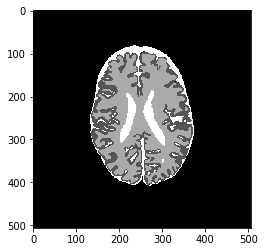

In [77]:
misc.imsave("GroundTrue.bmp",GT)
plt.imshow(GT,cmap='gray')

### (2) Result

In [101]:
test=np.zeros((fullpatch.shape[0],1,1))
test[:,0,0]=fullpatch[:,0,0,0]
test[index,0,0]=test_res[:,0]
test28=reconstruct_from_patches_2d(test,(height,height)) 

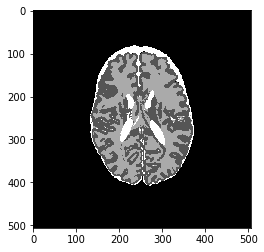

In [75]:
plt.imshow(test28,cmap='gray')

In [33]:
misc.imsave("p5_7_7tree_60.bmp",test28)

### (3)GM Prob

In [55]:
gm=c[:,0]
gm=gm.reshape((len(gm),1))
probgm=np.zeros((fullpatch.shape[0],1,1))
probgm[:,0,0]=fullpatch[:,0,0,0]
probgm[index,0,0]=gm[:,0]
gm=reconstruct_from_patches_2d(probgm,(height,height)) 

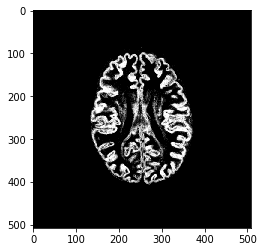

In [56]:
plt.imshow(gm,cmap='gray')

In [ ]:
misc.imsave("p5-7-7_gm.bmp",gm)

### (4) WM Prob

In [57]:
wm=c[:,1]
wm=wm.reshape((len(wm),1))
probwm=np.zeros((fullpatch.shape[0],1,1))
probwm[:,0,0]=fullpatch[:,0,0,0]
probwm[index,0,0]=wm[:,0]
wm=reconstruct_from_patches_2d(probwm,(height,height)) 

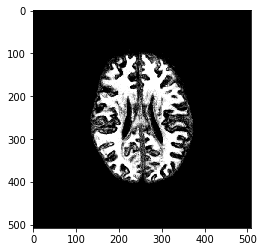

In [59]:
plt.imshow(wm,cmap='gray')

In [ ]:
misc.imsave("p5-7-7_wm.bmp",wm)

### (5) CSF Prob

In [64]:
csf=c[:,2]
csf=csf.reshape((len(csf),1))
probcsf=np.zeros((fullpatch.shape[0],1,1))
probcsf[:,0,0]=fullpatch[:,0,0,0]
probcsf[index,0,0]=csf[:,0]
csf=reconstruct_from_patches_2d(probcsf,(height,height)) 

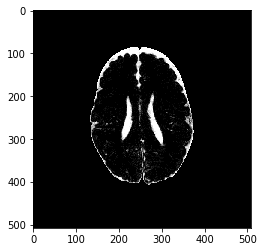

In [65]:
plt.imshow(csf,cmap='gray')

In [ ]:
misc.imsave("p19_csf.bmp",csf)